In [1]:
import tensorflow as tf
import pickle
import numpy as np
import os

CIFAR_DIR = "./cifar-10-batches-py"
print(os.listdir(CIFAR_DIR))

['batches.meta', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'readme.html', 'test_batch']


In [2]:
def load_data(filename):
    """read data from data file."""
    with open(filename,'rb') as f:
        data = pickle.load(f,encoding='latin1')
        return data['data'],data['labels']

class CifarData:
    def __init__(self, filenames, need_shuffle):
        all_data = []
        all_labels = []
        for filename in filenames[:2]:
            data,labels = load_data(filename)
            all_data.append(data)
            all_labels.append(labels)
        self._data = np.vstack(all_data) #纵向矩阵
        self._data = self._data / 127.5 - 1 #[0,255] -> [-1,1]
        self._labels = np.hstack(all_labels) #横向矩阵
        print(self._data.shape)
        print(self._labels.shape)
        self._num_examples = self._data.shape[0]
        self._need_shuffle = need_shuffle
        self._indicator = 0
        if self._need_shuffle:
            self._shuffle_data()
            
    def _shuffle_data(self):
        # [0,1,2,3,4,5] -> [5,3,2,4,0,1]
        p = np.random.permutation(self._num_examples)
        self._data = self._data[p]
        self._labels = self._labels[p]
        
    def next_batch(self,batch_size):
        """return batch_size examples as a batch."""
        end_indicator = self._indicator + batch_size
        if end_indicator > self._num_examples:
            if self._need_shuffle:
                self._shuffle_data()
                self._indicator = 0
                end_indicator = batch_size
            else:
                raise Exception("have no more examples")
        if end_indicator > self._num_examples:
            raise Exception("batch size is larger than all examples")
        batch_data = self._data[self._indicator:end_indicator]
        batch_labels = self._labels[self._indicator:end_indicator]
        self._indicator = end_indicator
        return batch_data, batch_labels

train_filenames = [os.path.join(CIFAR_DIR, 'data_batch_%d' % i) for i in range(1,6)]
test_filenames = [os.path.join(CIFAR_DIR, 'test_batch')]

train_data = CifarData(train_filenames, True)
test_data = CifarData(test_filenames, False)

#batch_data, batch_labels = train_data.next_batch(10)
#print(batch_data)
#print(batch_labels)

(20000, 3072)
(20000,)
(10000, 3072)
(10000,)


In [3]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32,[None,3072])
y = tf.placeholder(tf.int64,[None])
# [None], eg: [0,5,6,3]
x_image = tf.reshape(x, [-1,3,32,32])
x_image = tf.transpose(x_image, perm=[0,2,3,1])

# conv1_1： 神经元图， feature_map, 输出图像
conv1_1 = tf.layers.conv2d(x_image, 
                         32, # output channel number
                         (3,3), # kernel size
                         padding='same',
                         activation=tf.nn.relu,
                         name='conv1_1')
# conv1_2： 神经元图， feature_map, 输出图像
conv1_2 = tf.layers.conv2d(conv1_1, 
                         32, # output channel number
                         (3,3), # kernel size
                         padding='same',
                         activation=tf.nn.relu,
                         name='conv1_2')

# 16 * 16
pooling1 = tf.layers.max_pooling2d(conv1_2,
                                   (2,2), # kernel size
                                   (2,2), # stride
                                name='pool1')

# conv2_1： 神经元图、 feature_map, 输出图像
conv2_1 = tf.layers.conv2d(pooling1, 
                         32, # output channel number
                         (3,3), # kernel size
                         padding='same',
                         activation=tf.nn.relu,
                         name='conv2_1')
# conv2_2： 神经元图、 feature_map, 输出图像
conv2_2 = tf.layers.conv2d(conv2_1, 
                         32, # output channel number
                         (3,3), # kernel size
                         padding='same',
                         activation=tf.nn.relu,
                         name='conv2_2')

# 8 * 8
pooling2 = tf.layers.max_pooling2d(conv2_2,
                                   (2,2), # kernel size
                                   (2,2), # stride
                                name='pool2')

# conv3_1： 神经元图、 feature_map, 输出图像
conv3_1 = tf.layers.conv2d(pooling2, 
                         32, # output channel number
                         (3,3), # kernel size
                         padding='same',
                         activation=tf.nn.relu,
                         name='conv3_1')
# conv3_2： 神经元图、 feature_map, 输出图像
conv3_2 = tf.layers.conv2d(conv3_1, 
                         32, # output channel number
                         (3,3), # kernel size
                         padding='same',
                         activation=tf.nn.relu,
                         name='conv3_2')

# 4 * 4 * 32
pooling3 = tf.layers.max_pooling2d(conv3_2,
                                   (2,2), # kernel size
                                   (2,2), # stride
                                name='pool3')
# 展平[None, 4 * 4 * 32]
flatten = tf.layers.flatten(pooling3)
# 全连接层,输出
y_ = tf.layers.dense(flatten, 10)

# cross entropy
loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)
# y_ -> softmax
# y -> one_hot
# loss = ylogy_

# 十个里面概率最大的indices
predict = tf.argmax(y_, 1)
# [1,0,1,1,1,0,0,0]
correct_prediction = tf.equal(predict, y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float64))

with tf.name_scope('train_op'):
    train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
    #梯度下降的变种

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In [4]:
init = tf.global_variables_initializer()
glostep = []
acc_v = []
batch_size = 20
train_steps = 10000
test_steps = 100

with tf.Session() as sess:
    sess.run(init)
    for i in range(train_steps):
        batch_data, batch_labels = train_data.next_batch(batch_size)
        loss_val, acc_val, _ = sess.run(
            [loss,accuracy,train_op], 
            feed_dict = {
                x: batch_data,
                y: batch_labels
            })
        if (i+1) % 500 == 0:
            print("[Train] Step: %d, loss: %4.5f, acc: %4.5f" \
                   % (i+1,loss_val,acc_val))
            glostep.append(i+1)
            acc_v.append(acc_val)
        if (i+1) % 5000 == 0:
            test_data = CifarData(test_filenames, False)
            all_test_acc_val = []
            for j in range(test_steps):
                test_batch_data, test_batch_labels = test_data.next_batch(batch_size)
                test_acc_val = sess.run(
                    [accuracy],
                    feed_dict = {
                        x: test_batch_data,
                        y: test_batch_labels
                    })
                all_test_acc_val.append(test_acc_val)
            test_acc = np.mean(all_test_acc_val)
            print("[Test ] Step: %d, acc: %4.5f" \
                   % (i+1,test_acc))

[Train] Step: 500, loss: 1.79924, acc: 0.30000
[Train] Step: 1000, loss: 1.66503, acc: 0.40000
[Train] Step: 1500, loss: 1.24988, acc: 0.55000
[Train] Step: 2000, loss: 0.94041, acc: 0.80000
[Train] Step: 2500, loss: 1.06838, acc: 0.65000
[Train] Step: 3000, loss: 1.19853, acc: 0.70000
[Train] Step: 3500, loss: 0.75597, acc: 0.80000
[Train] Step: 4000, loss: 1.21400, acc: 0.70000
[Train] Step: 4500, loss: 0.75298, acc: 0.60000
[Train] Step: 5000, loss: 0.61574, acc: 0.80000
(10000, 3072)
(10000,)
[Test ] Step: 5000, acc: 0.66150
[Train] Step: 5500, loss: 0.71864, acc: 0.70000
[Train] Step: 6000, loss: 0.63663, acc: 0.80000
[Train] Step: 6500, loss: 0.76763, acc: 0.75000
[Train] Step: 7000, loss: 0.80708, acc: 0.80000
[Train] Step: 7500, loss: 0.42940, acc: 0.90000
[Train] Step: 8000, loss: 0.41596, acc: 0.90000
[Train] Step: 8500, loss: 0.56669, acc: 0.75000
[Train] Step: 9000, loss: 0.90390, acc: 0.65000
[Train] Step: 9500, loss: 0.75693, acc: 0.80000
[Train] Step: 10000, loss: 0.6198

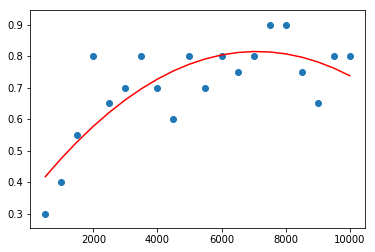

In [6]:
import matplotlib.pyplot as plt

fig=plt.figure()  #生成图片框架
ax=fig.add_subplot(1,1,1)  #连续性的画图
ax.scatter(glostep,acc_v)
parameter = np.polyfit(glostep, acc_v, 2)
f = np.poly1d(parameter)
ax.plot(glostep,f(glostep),c='r')
plt.ion() #不会show一下就停止显示（python新功能）
plt.show()